In [3]:
!wget https://nessie.ilab.sztaki.hu/~kornai/2024/AML/Resources/PetersonBarney.tar
!tar -xvf PetersonBarney.tar

--2024-09-14 14:37:54--  https://nessie.ilab.sztaki.hu/~kornai/2024/AML/Resources/PetersonBarney.tar
Resolving nessie.ilab.sztaki.hu (nessie.ilab.sztaki.hu)... 195.111.1.193
Connecting to nessie.ilab.sztaki.hu (nessie.ilab.sztaki.hu)|195.111.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57344 (56K) [application/x-tar]
Saving to: ‘PetersonBarney.tar’

PetersonBarney.tar  100%[===================>]  56.00K  --.-KB/s    in 0.1s    

2024-09-14 14:37:56 (392 KB/s) - ‘PetersonBarney.tar’ saved [57344/57344]

PetersonBarney/
PetersonBarney/HEADER
PetersonBarney/verified_pb.data
PetersonBarney/README


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import seaborn
from sklearn.metrics import confusion_matrix


# Data preparation

In [94]:
file_path = '/content/PetersonBarney/verified_pb.data'

df = pd.read_csv(file_path, delimiter='\t', header=None)
df.columns=["gender", "speaker", "phoneme", "asci", "f0", "f1", "f2", "f3"]
df

,gender,speaker,phoneme,asci,f0,f1,f2,f3
0,1,1,1,IY,160.0,240.0,2280.0,2850.0
1,1,1,1,IY,186.0,280.0,2400.0,2790.0
2,1,1,2,IH,203.0,390.0,2030.0,2640.0
3,1,1,2,IH,192.0,310.0,1980.0,2550.0
4,1,1,3,EH,161.0,490.0,1870.0,2420.0
...,...,...,...,...,...,...,...,...
1515,3,76,8,UH,322.0,610.0,1550.0,3400.0
1516,3,76,9,UW,345.0,520.0,1250.0,3460.0
1517,3,76,9,UW,334.0,500.0,1140.0,3380.0
1518,3,76,10,ER,308.0,740.0,1850.0,2160.0


In [7]:
filtered_df=df[df["asci"].str[0]!="*"]
filtered_df

,gender,speaker,phoneme,asci,f0,f1,f2,f3
0,1,1,1,IY,160.0,240.0,2280.0,2850.0
1,1,1,1,IY,186.0,280.0,2400.0,2790.0
2,1,1,2,IH,203.0,390.0,2030.0,2640.0
3,1,1,2,IH,192.0,310.0,1980.0,2550.0
4,1,1,3,EH,161.0,490.0,1870.0,2420.0
...,...,...,...,...,...,...,...,...
1515,3,76,8,UH,322.0,610.0,1550.0,3400.0
1516,3,76,9,UW,345.0,520.0,1250.0,3460.0
1517,3,76,9,UW,334.0,500.0,1140.0,3380.0
1518,3,76,10,ER,308.0,740.0,1850.0,2160.0


Random train-test split:

In [60]:
df_y=df["phoneme"]
df_X=df.drop("phoneme", axis=1).drop("asci", axis=1)

In [63]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df_X, df_y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

# Baseline modell: componentwise averages -> center of gravity for each class

In [65]:
train=pd.concat([X_train, y_train], axis=1)
centers=[]
for i in range(1, 11, 1):
   coords=(np.array(train[train["phoneme"]==i][["f0", "f1","f2","f3"]]))
   center=[sum(coords[:,j])/len(coords) for j in range(4)]
   centers.append(center)
print(centers)

[[196.2941176470588, 300.5966386554622, 2631.218487394958, 3231.176470588235], [199.192, 437.76, 2324.84, 2955.48], [190.79338842975207, 593.2066115702479, 2196.0, 2899.3553719008264], [180.79032258064515, 805.8709677419355, 1963.0967741935483, 2756.3306451612902], [186.98373983739836, 724.3658536585366, 1343.861788617886, 2708.8861788617887], [185.6206896551724, 841.2672413793103, 1200.4137931034484, 2737.4827586206898], [184.3969465648855, 594.7862595419847, 903.2595419847328, 2683.3053435114502], [200.1788617886179, 474.5121951219512, 1152.7479674796748, 2620.5365853658536], [203.15447154471545, 358.2520325203252, 970.0569105691056, 2615.471544715447], [193.45945945945945, 507.93693693693695, 1555.2522522522522, 1904.2342342342342]]


In [66]:
len(centers)

10

## Evaluation:

In [67]:
def nearest(test_data, centers):
    preds=[]
    for i in test_data:
        pred=np.argmin([np.sqrt(sum((i-center)**2)) for center in centers])+1
        preds.append(pred)
    return preds

### Validation set:

In [70]:
predictions=nearest(np.array(X_val[["f0","f1","f2","f3"]]), centers)
val_accuracy=accuracy_score(y_val, predictions)
val_accuracy

0.45394736842105265

### Test set:

In [71]:
predictions=nearest(np.array(X_test[["f0","f1","f2","f3"]]), centers)
test_accuracy=accuracy_score(y_test, predictions)
test_accuracy

0.5723684210526315

confusion matrix:

<Axes: >

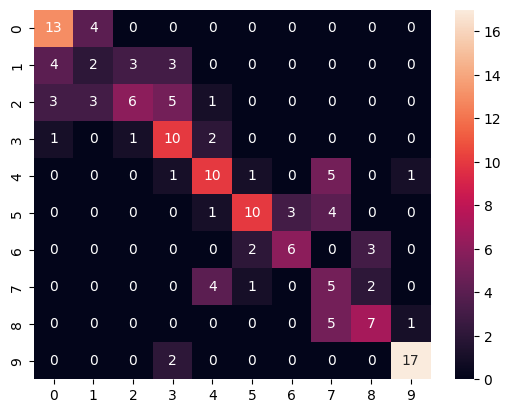

In [90]:
conf_matrix=confusion_matrix(y_test, predictions)
seaborn.heatmap(conf_matrix, annot=True)


### without the *-marked datapoints:

In [72]:
filtered_df_y=filtered_df["phoneme"]
filtered_df_X=filtered_df.drop("phoneme", axis=1).drop("asci", axis=1)

X_train_val_f, X_test_f, y_train_val_f, y_test_f = train_test_split(filtered_df_X, filtered_df_y, test_size=0.1, random_state=42)
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

train_f=pd.concat([X_train_f, y_train_f], axis=1)
centers_f=[]
for i in range(1, 11, 1):
   coords=(np.array(train_f[train_f["phoneme"]==i][["f0", "f1","f2","f3"]]))
   center=[sum(coords[:,j])/len(coords) for j in range(4)]
   centers_f.append(center)


predictions=nearest(np.array(X_val_f[["f0","f1","f2","f3"]]), centers_f)
val_accuracy=accuracy_score(y_val_f, predictions)
print(f"Validation accuracy is {val_accuracy}")

predictions=nearest(np.array(X_test_f[["f0","f1","f2","f3"]]), centers_f)
test_accuracy=accuracy_score(y_test_f, predictions)
print(f"Test accuracy is {test_accuracy}")

Validation accuracy is 0.45394736842105265
Test accuracy is 0.475


### Without using f0:

In [73]:
centers_without_f0=[]
for i in range(1, 11, 1):
   coords=(np.array(train_f[train_f["phoneme"]==i][["f1","f2","f3"]]))
   center=[sum(coords[:,j])/len(coords) for j in range(3)]
   centers_without_f0.append(center)


predictions=nearest(np.array(X_val[["f1","f2","f3"]]), centers_without_f0)
val_accuracy=accuracy_score(y_val, predictions)
print(f"Validation accuracy is {val_accuracy}")

predictions=nearest(np.array(X_test[["f1","f2","f3"]]), centers_without_f0)
test_accuracy=accuracy_score(y_test, predictions)
print(f"Test accuracy is {test_accuracy}")

Validation accuracy is 0.4473684210526316
Test accuracy is 0.5657894736842105


# More complicated model

Validation accuracy is 0.8618421052631579
Validation accuracy is 0.9013157894736842


<Axes: >

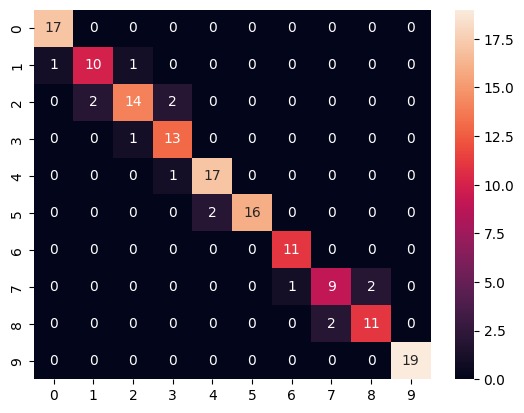

In [91]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

val_preds=rf.predict(X_val)
val_acc=accuracy_score(y_val, val_preds)
print(f"Validation accuracy is {val_acc}")

test_preds=rf.predict(X_test)
test_acc=accuracy_score(y_test, test_preds)
print(f"Validation accuracy is {test_acc}")

conf_matrix=confusion_matrix(y_test, test_preds)
seaborn.heatmap(conf_matrix, annot=True)

## Crossvalidation for the number of estimators (trees in the forest)

<Axes: xlabel='n_estimators', ylabel='accuracy'>

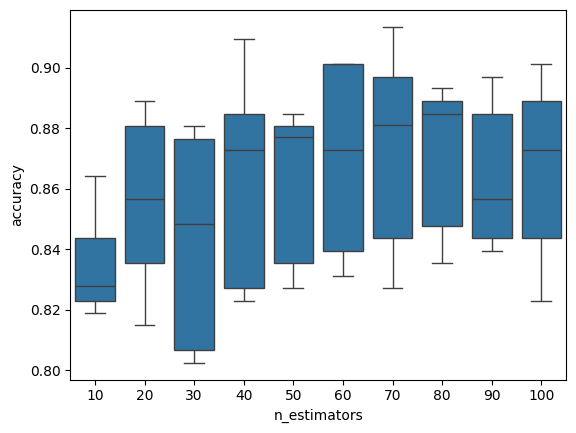

In [83]:

n_estimators=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
l=[]
for i in range(len(n_estimators)):
    cv=model_selection.cross_val_score(RandomForestClassifier(n_estimators=n_estimators[i]), X_train, y_train, cv=5, scoring="accuracy")
    for j in cv:
        l.append((n_estimators[i],j))
df=pd.DataFrame(l)
df = df.rename(columns={0: 'n_estimators', 1: 'accuracy'})
seaborn.boxplot(x='n_estimators',y='accuracy', data=df, order=n_estimators)

n_estimators=80 is the best parameter

Validation accuracy is 0.875
Validation accuracy is 0.9210526315789473


<Axes: >

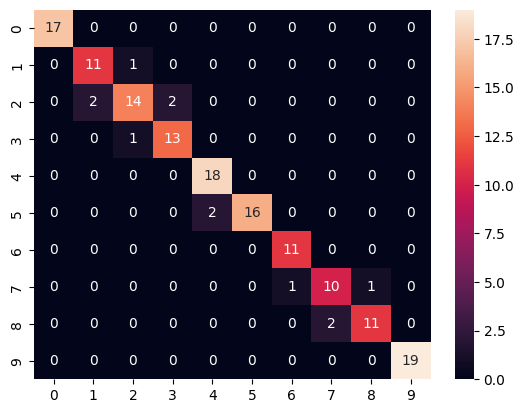

In [92]:
rf = RandomForestClassifier(n_estimators=80)
rf.fit(X_train, y_train)

val_preds=rf.predict(X_val)
val_acc=accuracy_score(y_val, val_preds)
print(f"Validation accuracy is {val_acc}")

test_preds=rf.predict(X_test)
test_acc=accuracy_score(y_test, test_preds)
print(f"Validation accuracy is {test_acc}")

conf_matrix=confusion_matrix(y_test, test_preds)
seaborn.heatmap(conf_matrix, annot=True)